# Reading and writing SAMOS .nc files with samosxarray

In [9]:
import os
import samosxarray as sx
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## samosxarray.open_dataset(filepath)

samosxarray.open_dataset(filepath) returns an xarray Dataset where the values in each DataArray are set to np.nan based on the lists of good_flags or bad_flags provided. If no list of flags are provided, this array only contains values flagged as "Z", which means "good data".

samosxarray also automatically fixes RH data over 100% by default, but this can be disabled by adding the "fix_rh_over_100=False" argument to open_dataset. This fix involves taking RH data that is between 100-105% and has qc flag "B", adjusting the value to 100%, and changing the flag to "Z". “B” indicates that original data were out of a physically realistic range of 0-100%. This code is often applied in conditions where relative humidity is close to 100% because the instrument erroneously reads slightly above 100%. This can occur when relative humidity sensors are tuned to be more responsive in the upper humidity range, which can cause the readings to “overshoot” when saturation conditions exist (Briggs and Smith 2022; Wiederhold 1997).

This samosxarray Dataset can be treated like any other xarray Dataset. For example, printing the dataset will give a summary of its contents.

In [10]:
filepath = 'WCX7445_20111009v30001.nc'
    
print(f'Opening {filepath}')

ds = sx.open_dataset(filepath)

print(ds)

Opening WCX7445_20111009v30001.nc
<xarray.Dataset>
Dimensions:   (time: 1440, f_string: 23, h_num: 50, h_string: 236)
Coordinates:
  * time      (time) datetime64[ns] 2011-10-09 ... 2011-10-09T23:59:00
  * f_string  (f_string) int64 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: h_num, h_string
Data variables: (12/24)
    lat       (time) float32 -56.32 -56.32 -56.33 ... -59.91 -59.91 -59.91
    lon       (time) float32 296.4 296.4 296.4 296.4 ... 300.3 300.3 300.3 300.3
    PL_HD     (time) float32 149.6 147.8 149.4 149.8 ... 146.5 148.7 147.2 145.7
    PL_CRS    (time) float32 151.5 149.7 151.2 149.6 ... 149.4 151.3 150.3 150.2
    DIR       (time) float32 334.5 336.1 336.5 335.5 ... 350.5 350.6 347.7 349.6
    DIR2      (time) float32 340.5 340.4 342.0 340.8 ... 354.7 354.3 353.3 353.6
    ...        ...
    CNDC      (time) float32 3.31 3.3 3.3 3.3 3.31 ... 2.81 2.81 2.81 2.81 2.81
    RAD_PAR   (time) float32 nan nan nan nan nan nan ... nan nan na

## samosxarray.ds_flag_summary(ds)

samosxarray also adds some functionality specific to SAMOS Datasets. For example, the samosxarray.ds_flag_summary(ds) function gives a list of the data variables in the dataset with a list of flags applied to each data variable, the flag meaning, and how many values have that flag applied.

In [11]:
print(sx.ds_flag_summary(ds))


SAMOS flags:
    lat (degree) [latitude (degrees (+N))]
        Z (Good data): 1440 (100.0%)
    lon (degree) [longitude (degrees (-W/+E))]
        Z (Good data): 1440 (100.0%)
    PL_HD (degree) [platform heading (degrees (clockwise towards true north))]
        Z (Good data): 1440 (100.0%)
    PL_CRS (degree) [platform course (degrees (clockwise towards true north))]
        Z (Good data): 1440 (100.0%)
    DIR (degree) [earth relative wind direction port (degrees (clockwise from true north))]
        K (Suspect - visual): 110 (7.6%)
        S (Spike - visual): 7 (0.5%)
        Z (Good data): 1323 (91.9%)
    DIR2 (degree) [earth relative wind direction starboard (degrees (clockwise from true north))]
        K (Suspect - visual): 18 (1.2%)
        Z (Good data): 1422 (98.8%)
    PL_WDIR (degree) [platform relative wind direction port (degrees (clockwise from bow))]
        Z (Good data): 1440 (100.0%)
    PL_WDIR2 (degree) [platform relative wind direction starboard (degrees (clock

## Metpy calculations and quantify

Metpy adds the ability to "quantify" a DataArray, which returns a masked array with units applied based on the units specified in the DataArray "units" attribute. These "unit aware" values can then be used in Metpy calculations that will automatically handle any unit conversions necessary.

In [12]:
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature=ds['T'].metpy.quantify(), relative_humidity=ds['RH'].metpy.quantify())

print(f"{dewpoint = }")

dewpoint = <xarray.DataArray (time: 1440)>
<Quantity([4.6131897  4.6183777  4.6131897  ... 0.48999023 0.47000122 0.45999146], 'degree_Celsius')>
Coordinates:
  * time     (time) datetime64[ns] 2011-10-09 ... 2011-10-09T23:59:00


## Plotting calculation results alongside input data

Metpy calculations can take single values or xarray DataArrays. When given DataArrays as input, the calculation returns a DataArray which can then be treated like the other DataArrays from the Dataset. For example, they can be plotted alongside each other because they have the same dimensions/coordinates.

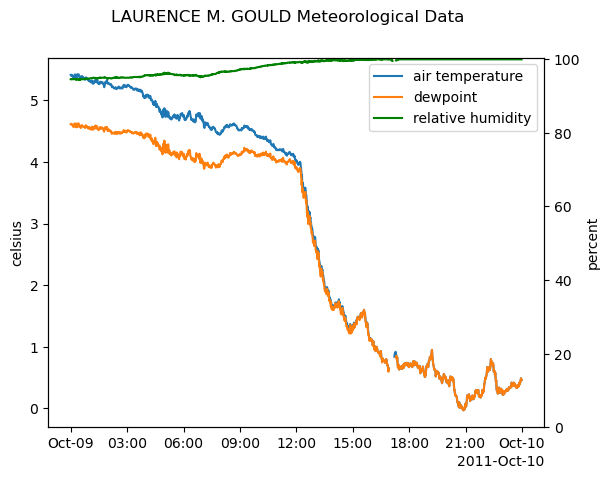

In [13]:
fig, ax1 = plt.subplots()
fig.suptitle(ds.title)

ax1.set_ylabel(ds['T'].units)

ax2 = ax1.twinx()
ax2.set_ylabel(ds['RH'].units)
ax2.set_ylim(0, 100.5)

t_plot, = ax1.plot(ds.time, ds['T'], label=ds['T'].long_name)
rh_plot, = ax2.plot(ds.time, ds['RH'], c='green', label=ds['RH'].long_name)
dewpoint_plot, = ax1.plot(ds.time, dewpoint, label='dewpoint')

ax1.xaxis.set_major_formatter(
mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

ax1.legend([t_plot, dewpoint_plot, rh_plot], [t_plot.get_label(), dewpoint_plot.get_label(), rh_plot.get_label()])

plt.show()

## samosxarray.var_flag_summary(ds, var_name)

samosxarray also provides functions getting and setting flags. samosxarray.var_flag_summary(ds, var_name) returns a flag summary as demonstrated earlier, but for a single variable.

In [14]:
print(sx.var_flag_summary(ds, var_name='SSPS'))


    SSPS (g kg-1) [salinity (PSU)]
        Z (Good data): 1440 (100.0%)


## samosxarray.get_var_flags(ds, var_name)

SAMOS datasets store flags as a 2-D array, where one dimension is the variable's qcindex and the other dimension is time. samosxarray.get_var_flags(ds, var_name) returns a 1-D DataArray with the flags for that specific variable.

In [15]:
salinity_flags = sx.get_var_flags(ds, var_name='SSPS')
print(salinity_flags)

<xarray.DataArray 'flag' (time: 1440)>
array([b'Z', b'Z', b'Z', ..., b'Z', b'Z', b'Z'], dtype='|S1')
Coordinates:
  * time      (time) datetime64[ns] 2011-10-09 ... 2011-10-09T23:59:00
    f_string  int64 19
Attributes: (12/26)
    long_name:  quality control flags
    A:          Units added
    B:          Data out of range
    C:          Non-sequential time
    D:          Failed T>=Tw>=Td
    E:          True wind error
    ...         ...
    T:          Time duplicate
    U:          Suspect - statistial
    V:          Spike - statistical
    X:          Step - statistical
    Y:          Suspect between X-flags
    Z:          Good data


## samosxarray.update_flag(ds, var_name, index, new_flag_value)

samosxarray.update_flag(ds, var_name, index, new_flag_value) provides a simple way to change the flag for a single value. This can be called in a loop to flag a range of indices.

In [16]:
for index in range(100,200):
    ds = sx.update_flag(ds, 'SSPS', index, b'K')

print(sx.var_flag_summary(ds, 'SSPS'))


    SSPS (g kg-1) [salinity (PSU)]
        K (Suspect - visual): 100 (6.9%)
        Z (Good data): 1340 (93.1%)


## samosxarray.to_samos_netcdf(filepath)

samosxarray.to_samos_netcdf(filepath) saves the samosxarray Dataset to a .nc file. This uses the xarray.to_netcdf(filepath) function, but applies settings necessary for SAMOS .nc files:
- NETCDF3_CLASSIC format
- "minutes since 1980-1-1 0:0:0" time units

This function also uses the ncwa and ncatted command line tools from NCO to remove the extra dimension (called "string1") that xarray adds when saving a NETCDF3_CLASSIC dataset that contains a character array (the flag 2-D array). If you are running this in an environment that does not have NCO installed, you can disable this part of the function by adding the argument fix_dims=False.

In [17]:
sx.to_samos_netcdf(ds, 'demo.nc')

ds.close()

We can check that this worked by opening the file we created, printing its contents, closing it, and deleting it.

In [18]:
ds = sx.open_dataset('demo.nc')

print(ds)
print(sx.ds_flag_summary(ds))

ds.close()

os.remove('demo.nc')

<xarray.Dataset>
Dimensions:   (time: 1440, f_string: 23, h_num: 50, h_string: 236)
Coordinates:
  * time      (time) datetime64[ns] 2011-10-09 ... 2011-10-09T23:59:00
  * f_string  (f_string) int64 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: h_num, h_string
Data variables: (12/24)
    lat       (time) float32 -56.32 -56.32 -56.33 ... -59.91 -59.91 -59.91
    lon       (time) float32 296.4 296.4 296.4 296.4 ... 300.3 300.3 300.3 300.3
    PL_HD     (time) float32 149.6 147.8 149.4 149.8 ... 146.5 148.7 147.2 145.7
    PL_CRS    (time) float32 151.5 149.7 151.2 149.6 ... 149.4 151.3 150.3 150.2
    DIR       (time) float32 334.5 336.1 336.5 335.5 ... 350.5 350.6 347.7 349.6
    DIR2      (time) float32 340.5 340.4 342.0 340.8 ... 354.7 354.3 353.3 353.6
    ...        ...
    CNDC      (time) float32 3.31 3.3 3.3 3.3 3.31 ... 2.81 2.81 2.81 2.81 2.81
    RAD_PAR   (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    RAD_NET   (time)